In [70]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

datasets = {0:'tabula-muris-heart', 1:'tabula-muris-marrow_P7_2', 2:'tabula-muris-marrow_P7_3', 3:'peripheal-blood', 4:'kumar-4-hard', 5:'kumar-8-hard'}
num_of_clusters = {0:5, 1:14, 2:14, 3:12, 4:4, 5:8}
datasetNum = 5

ToolName = 'scanpy' 
DatasetName = datasets[datasetNum]
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)

if not os.path.exists(save_path):
    os.makedirs(save_path)
    

In [71]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

In [72]:
scale_factor = 10000

sc.pp.normalize_per_cell(adata) # same as seurat NormalizeData

adata.X = adata.X * scale_factor # seurat scale.factor

sc.pp.log1p(adata)

# sc.pp.scale(adata)  # mean=0, var=1

In [73]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [74]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
# same number of PCs as seurat

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


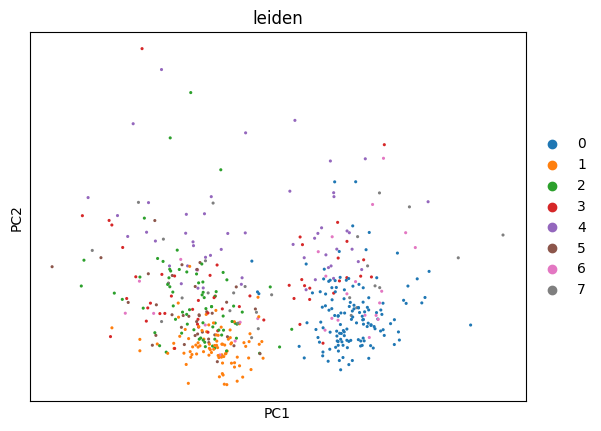

In [75]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)    # 15 è il default di scanpy
# forse n_neighbors è l'equivalente di k.param in seurat

sc.tl.leiden(adata, resolution=0.059)

res = 0.01
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters[datasetNum],) or res == 1.0:
    res += 0.01
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [76]:
# cluster id for each cell renamed as cluster

df = pd.DataFrame(adata.obs['leiden'])

labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'

labels['cluster'] = labels['cluster'].astype(int) + 1

labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

In [77]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, labels, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


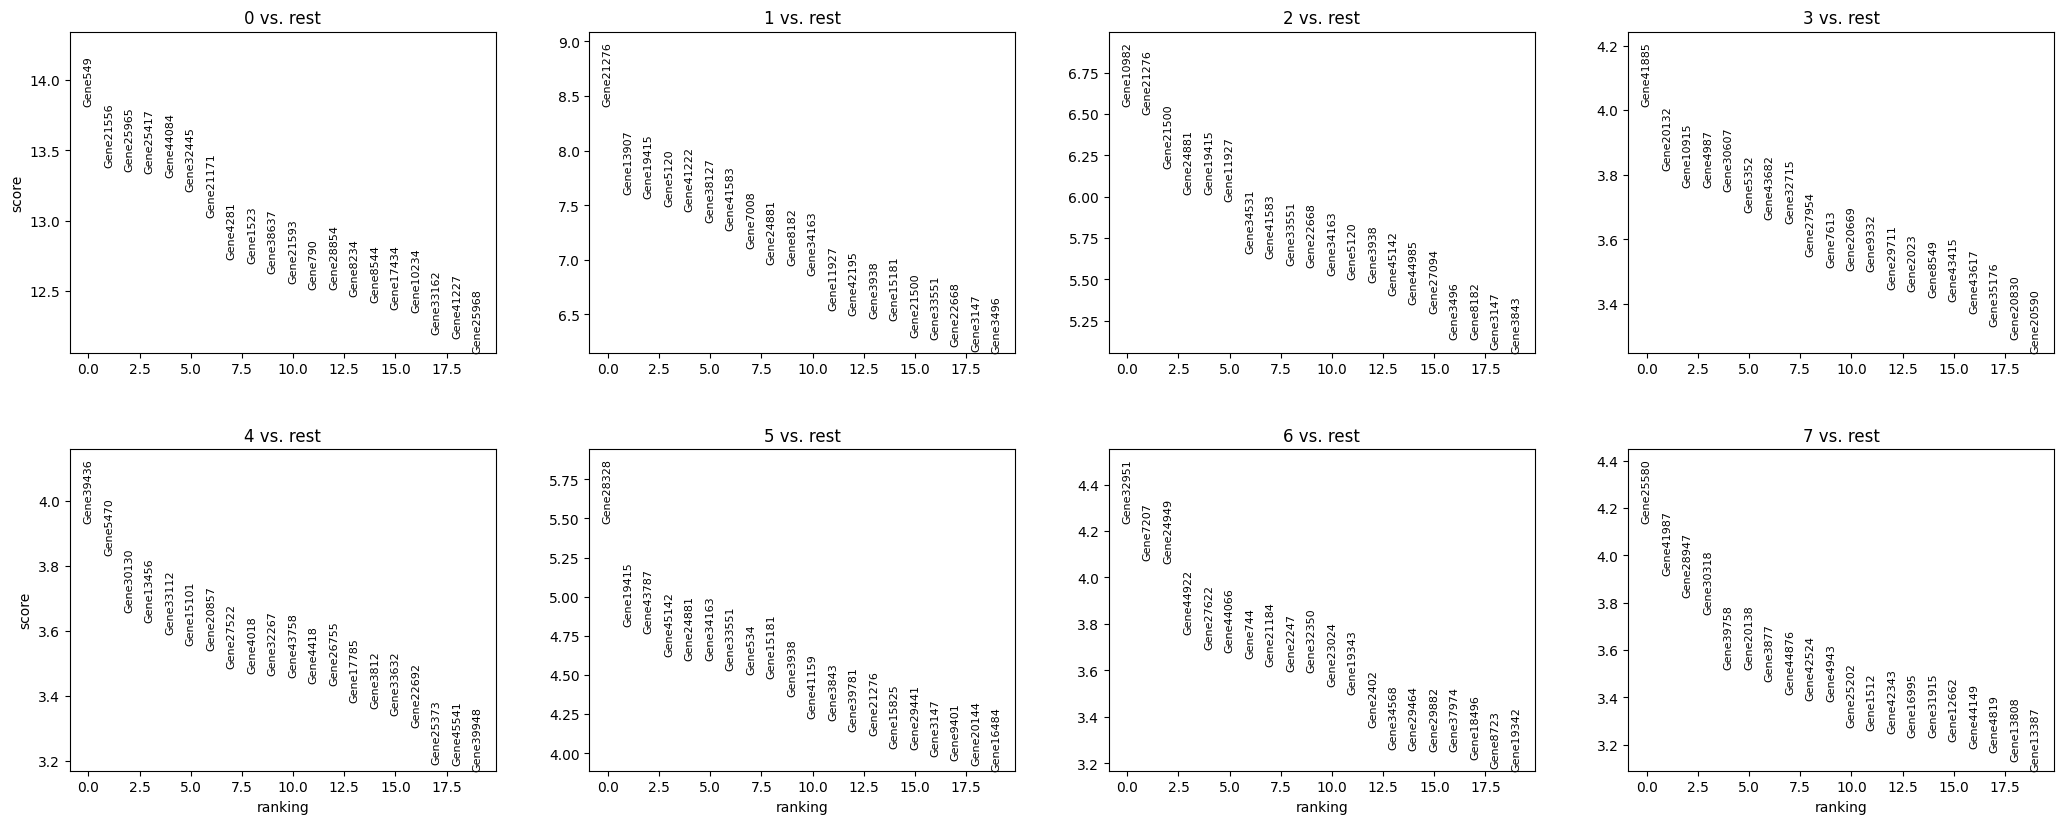

In [78]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # method='wilcoxon' method='logreg'
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [79]:
number_of_clusters = num_of_clusters[datasetNum]
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)

# other things

In [11]:
sc.tl.pca(adata, svd_solver='arpack')

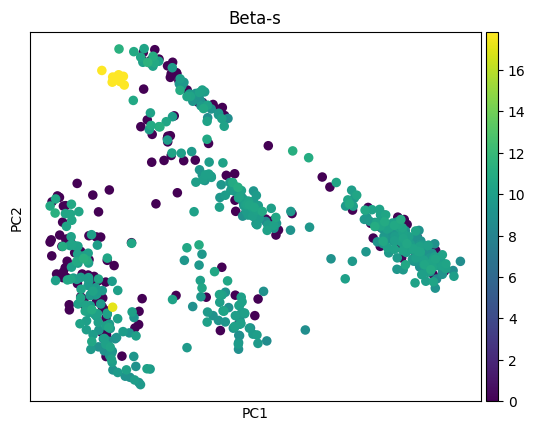

In [12]:
sc.pl.pca(adata, color='Beta-s')

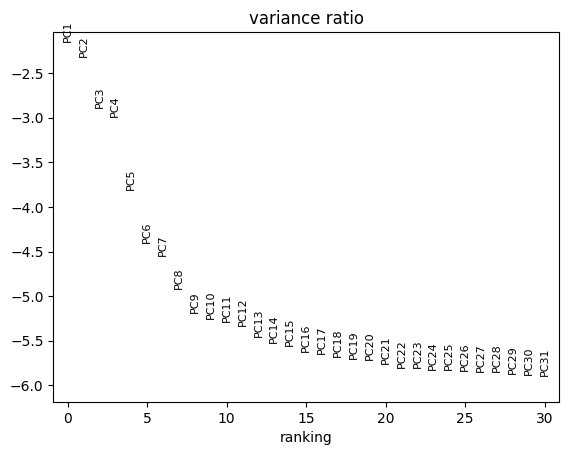

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)

In [14]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [15]:
sc.tl.umap(adata)

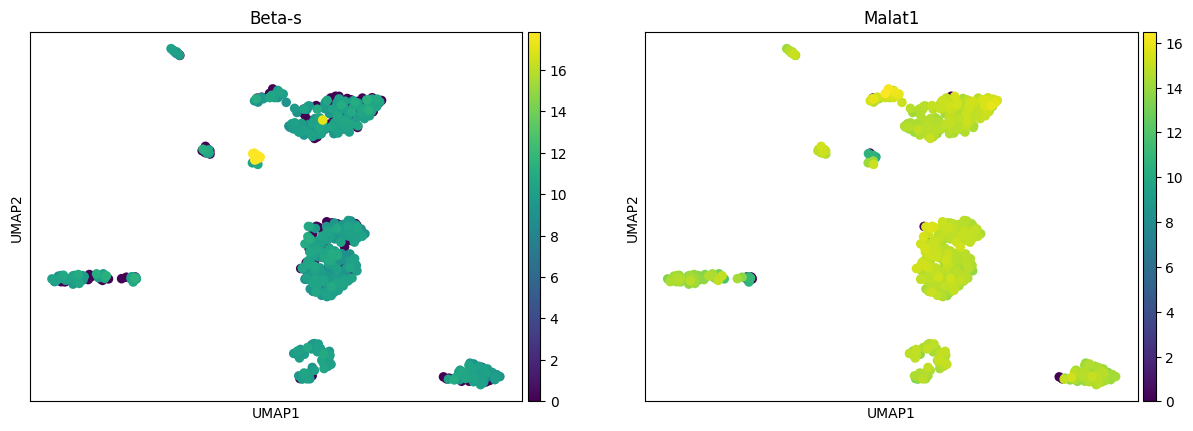

In [16]:
sc.pl.umap(adata, color=['Beta-s', 'Malat1'])

In [17]:
sc.tl.leiden(adata, resolution=0.4)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


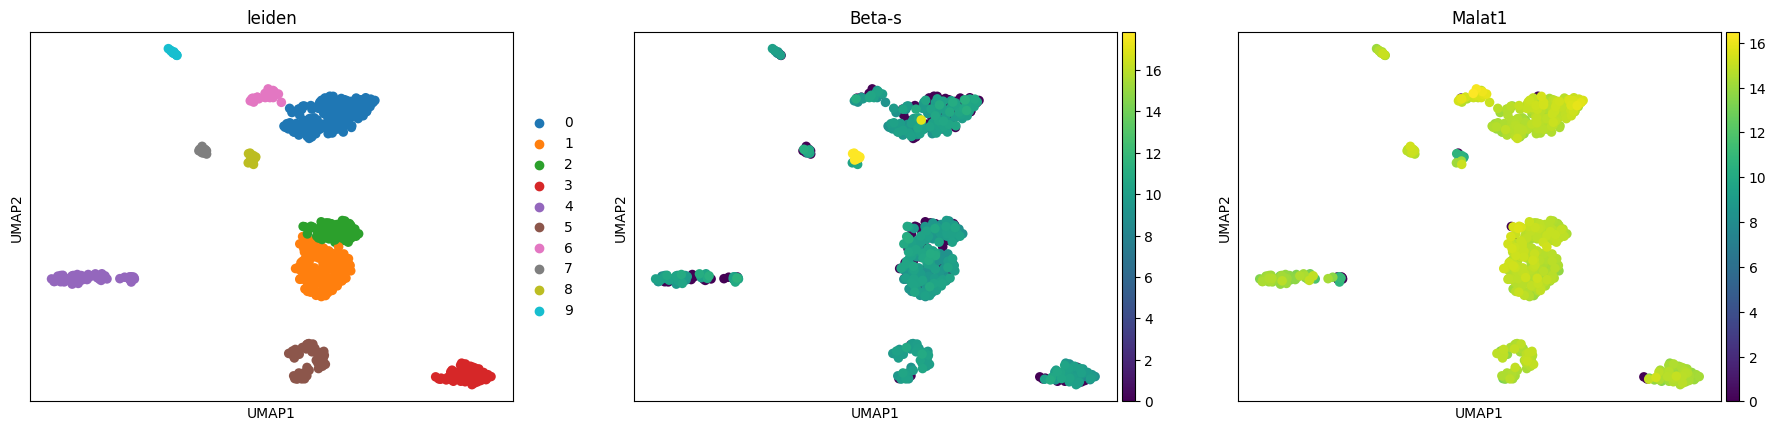

In [18]:
sc.pl.umap(adata, color=['leiden', 'Beta-s', 'Malat1'])

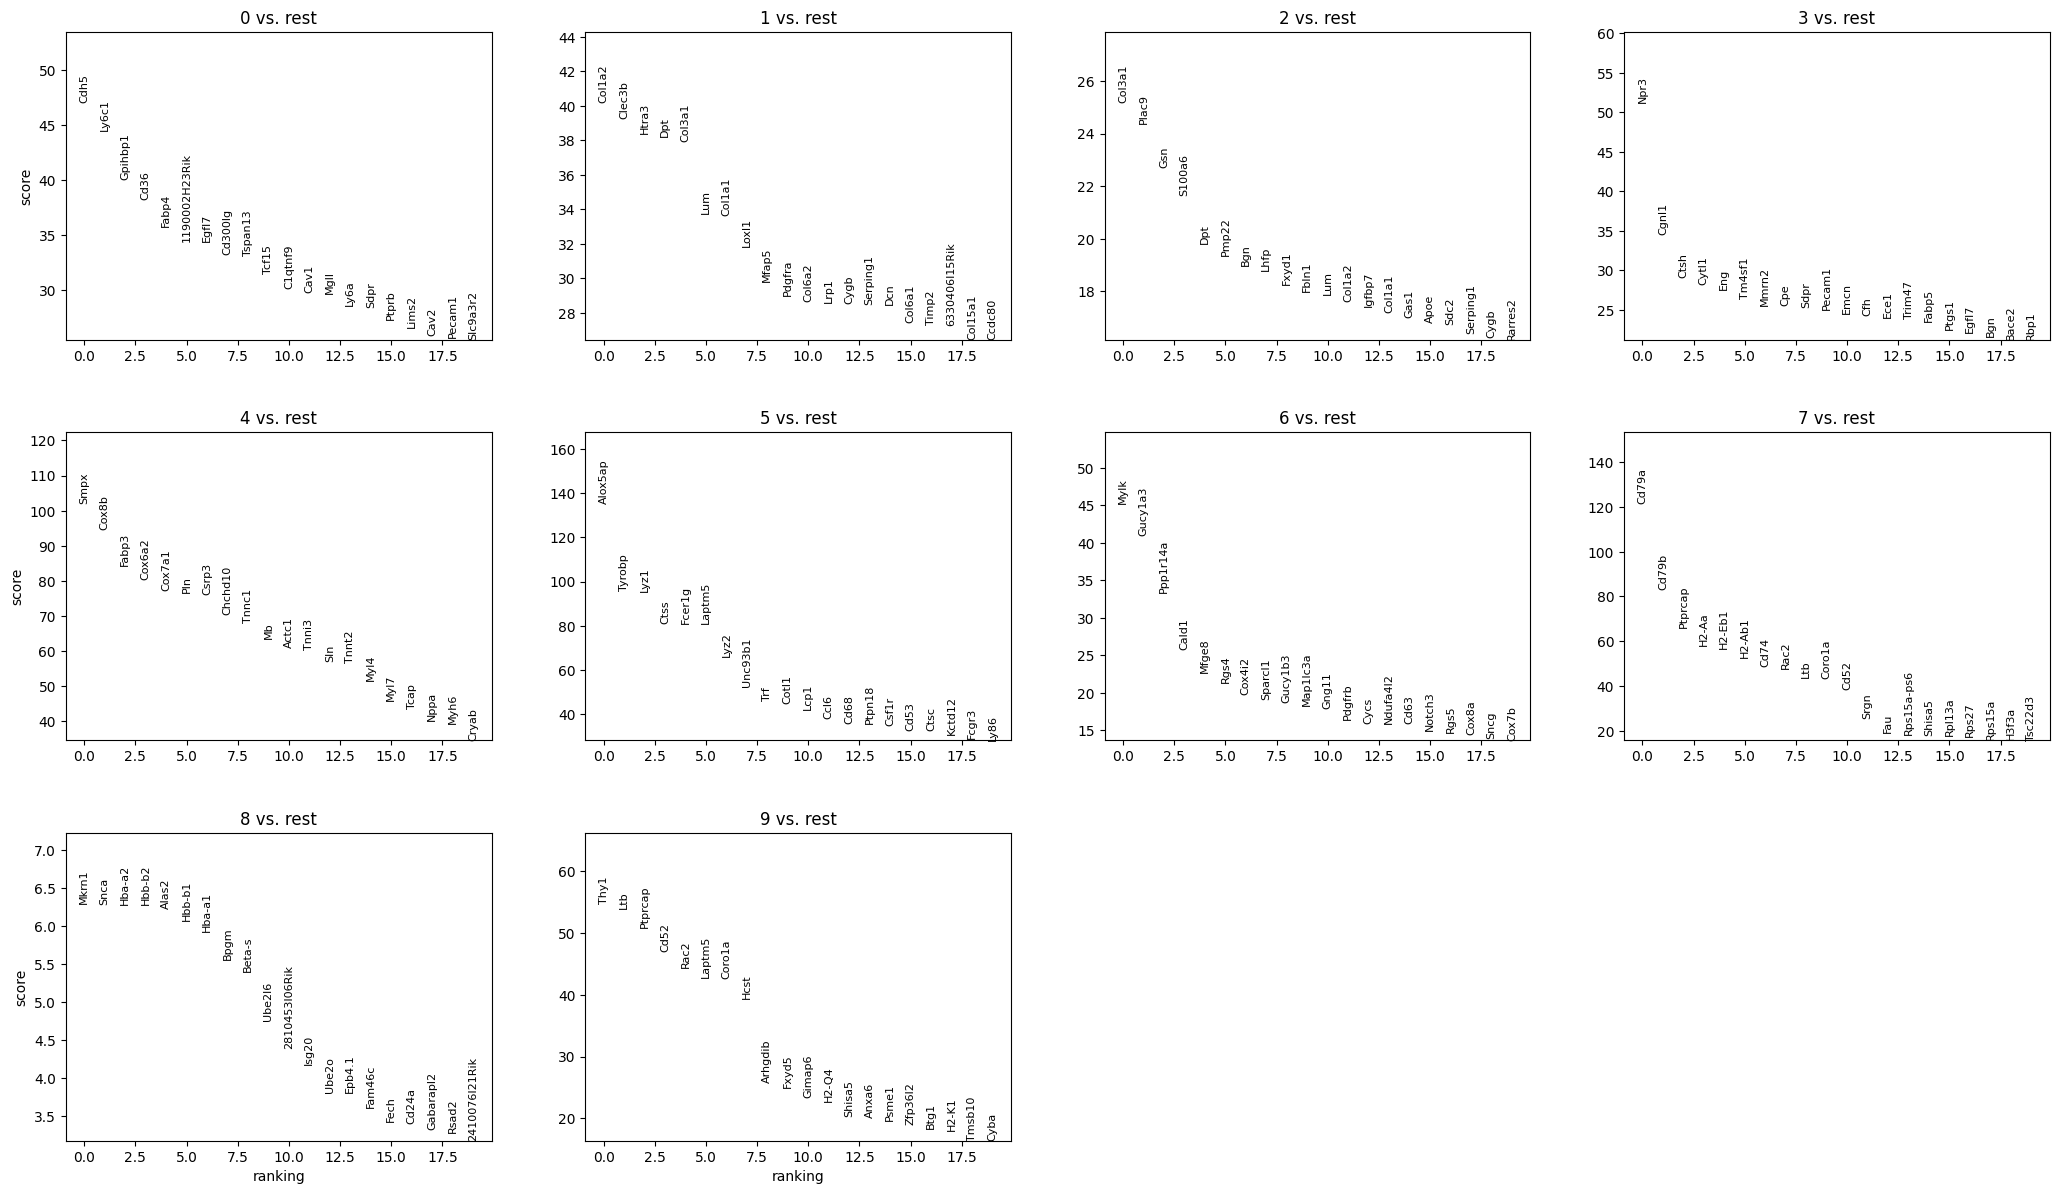

In [19]:
ret = sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [20]:
number_of_clusters = 8
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(0, number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)

df

,gene,cluster,rank
0,Cdh5,0,0
1,Ly6c1,0,1
2,Gpihbp1,0,2
3,Cd36,0,3
4,Fabp4,0,4
...,...,...,...
155,Rpl13a,7,15
156,Rps27,7,16
157,Rps15a,7,17
158,H3f3a,7,18


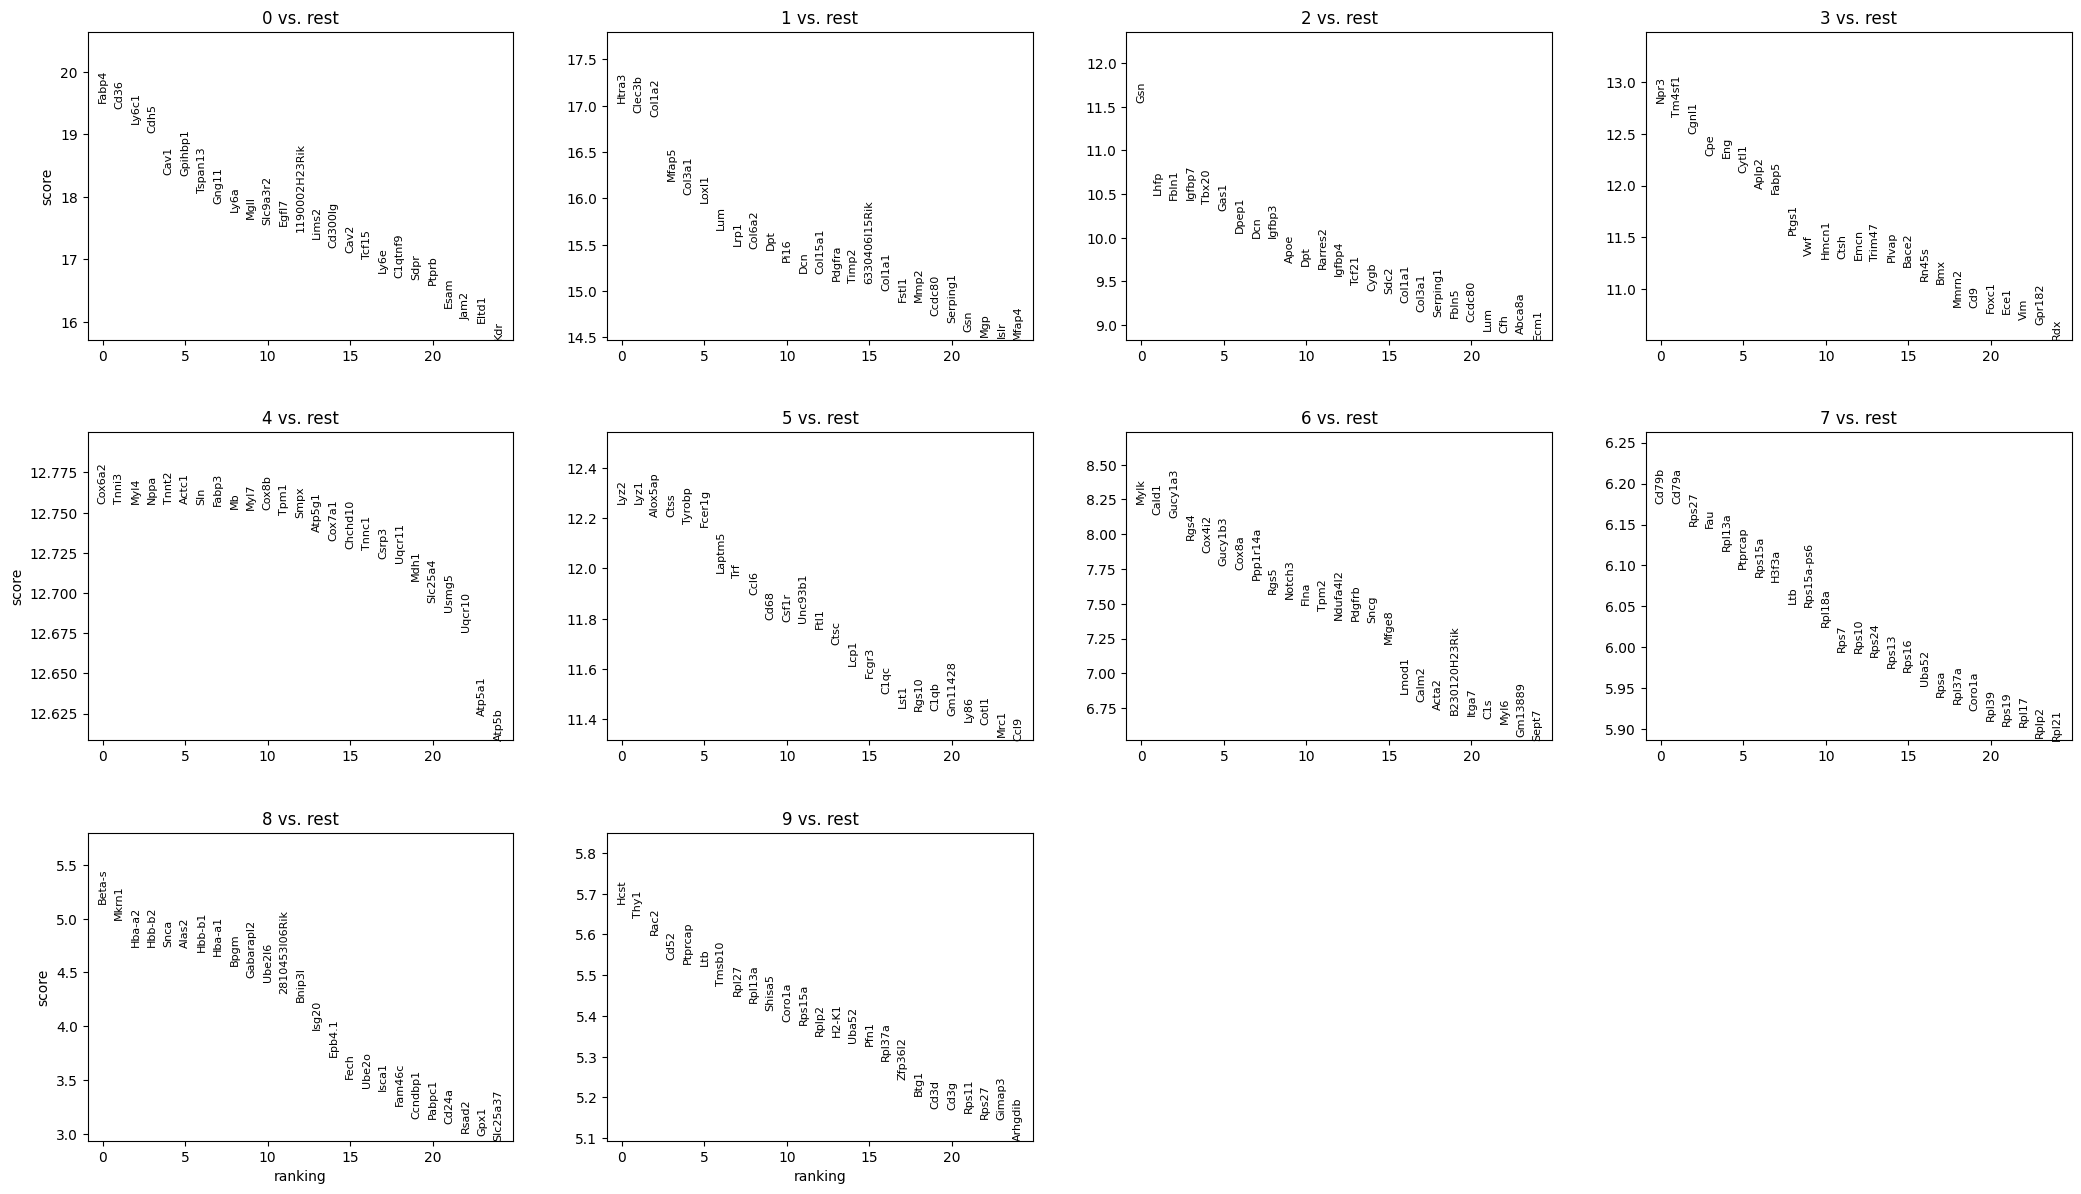

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


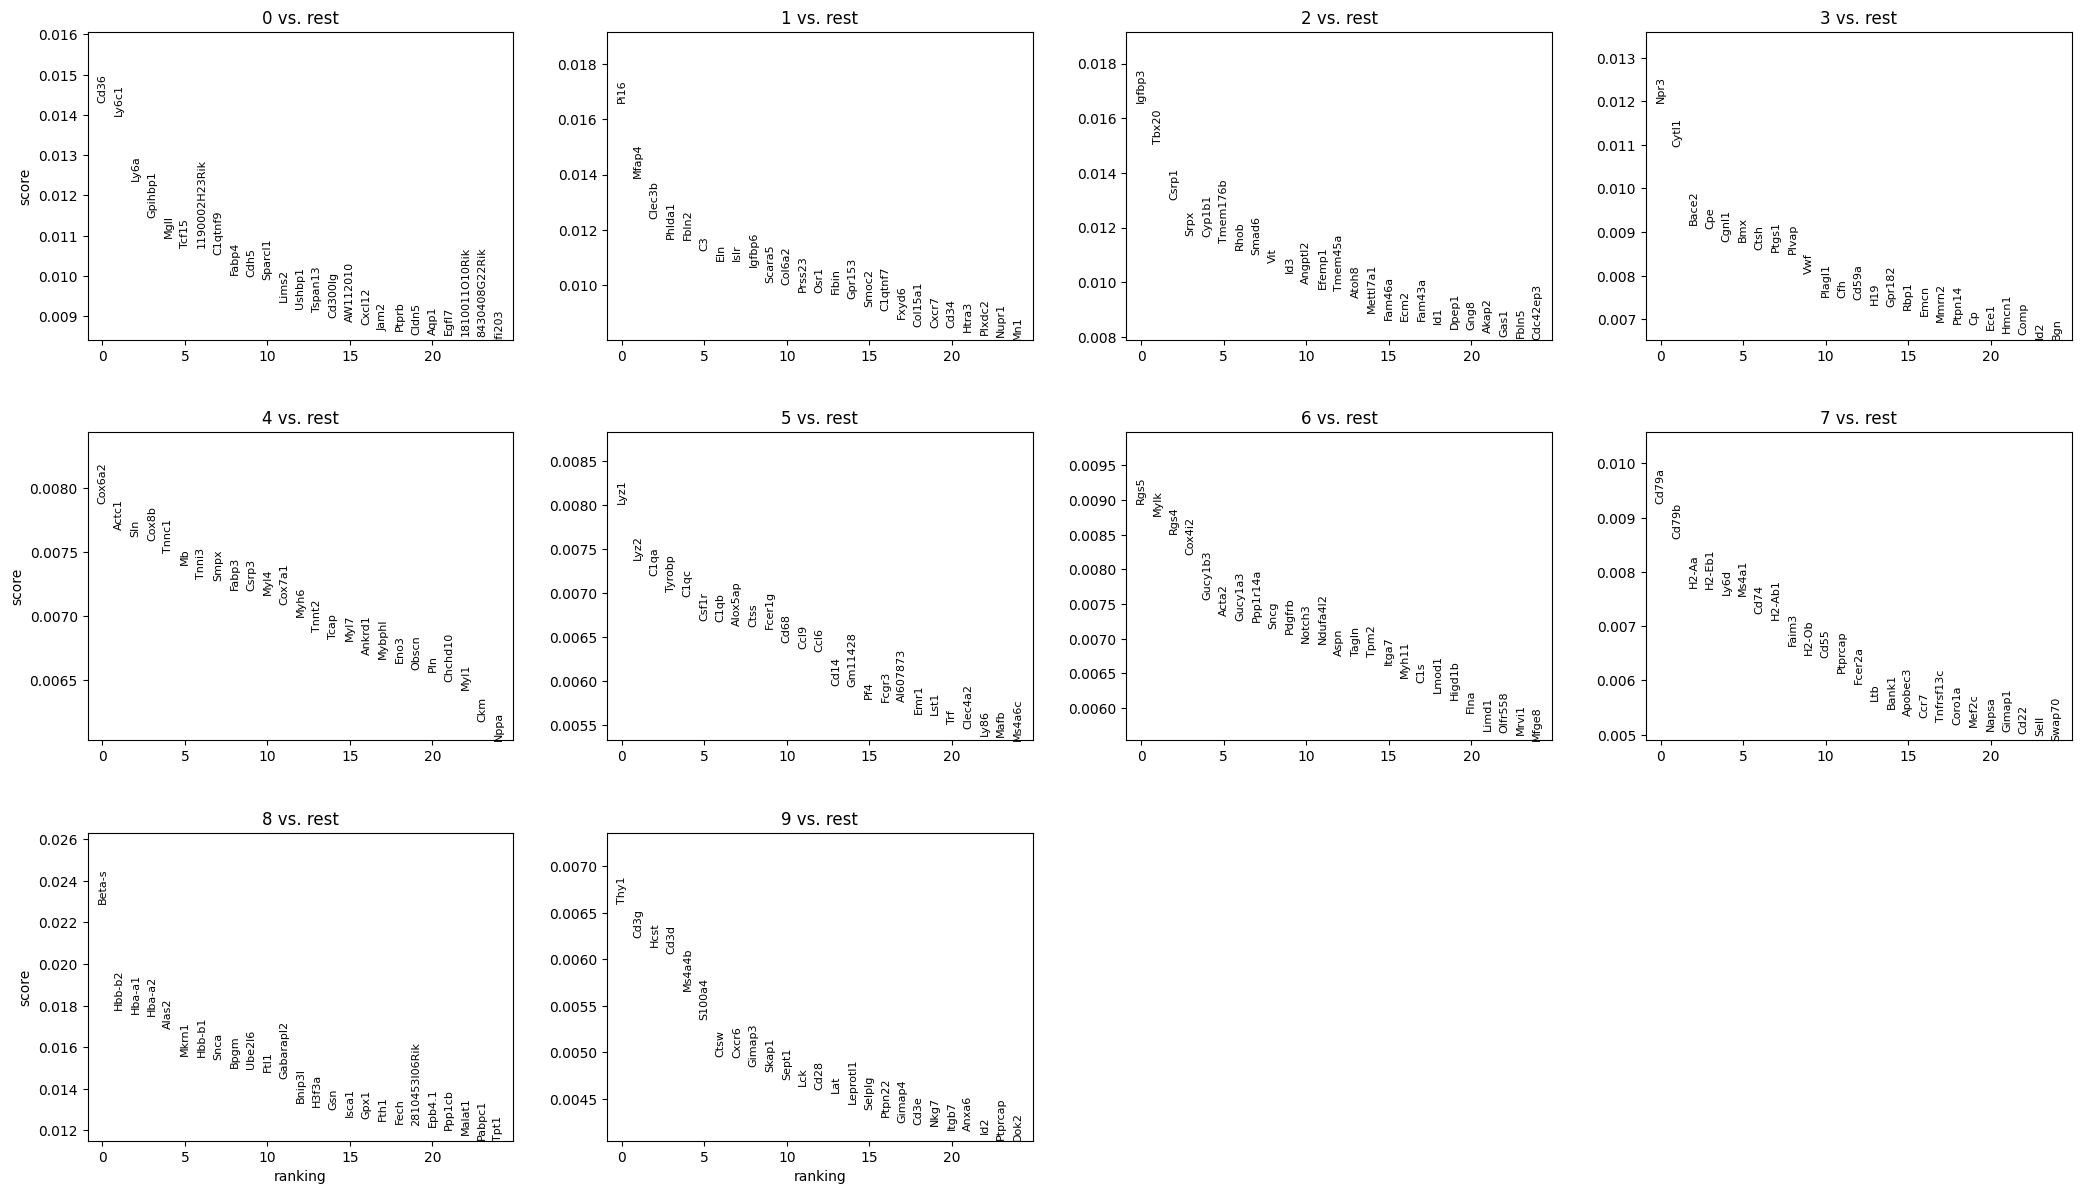

In [22]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [23]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

In [24]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


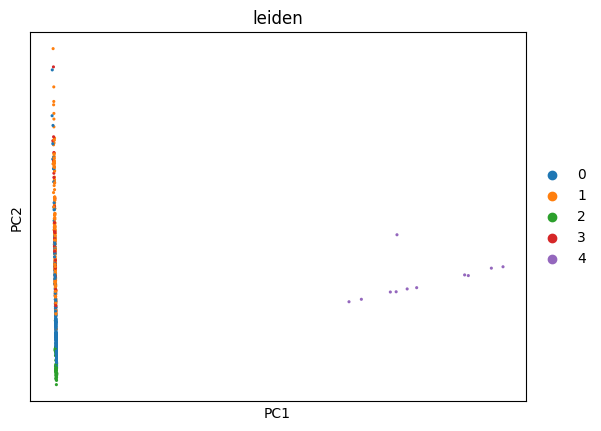

In [25]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)    # 15 è il default di scanpy
# forse n_neighbors è l'equivalente di k.param in seurat

sc.tl.leiden(adata, resolution=0.059)

sc.pl.pca(adata, color=['leiden'], size=20)


In [26]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, labels, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
number_of_clusters = num_of_clusters[datasetNum]
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)

KeyError: 'rank_genes_groups'

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

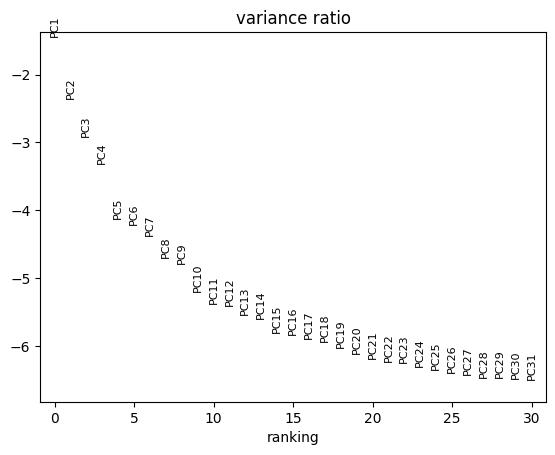

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.tl.leiden(adata, resolution=0.4)

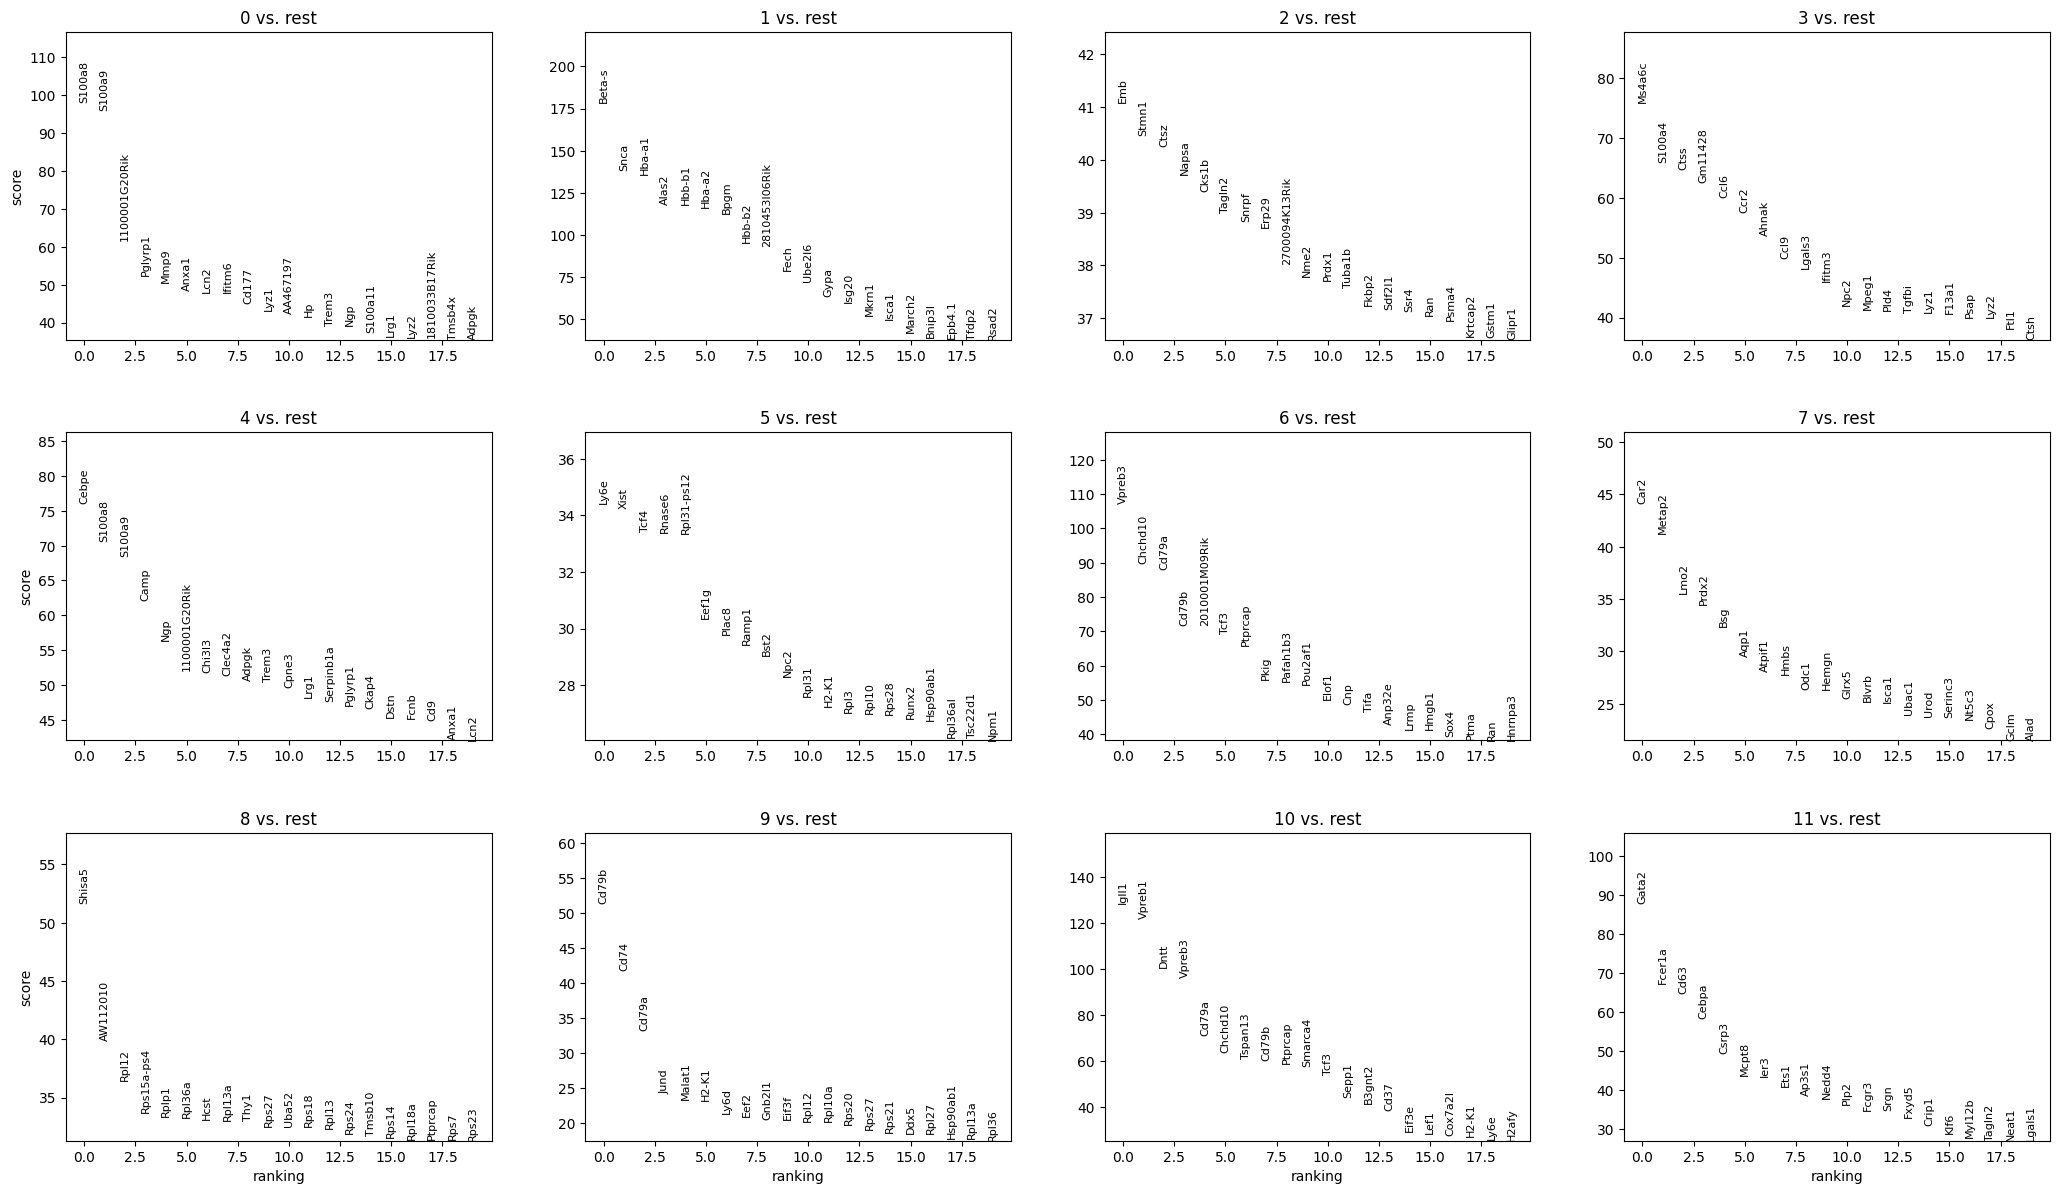

In [ ]:
ret = sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

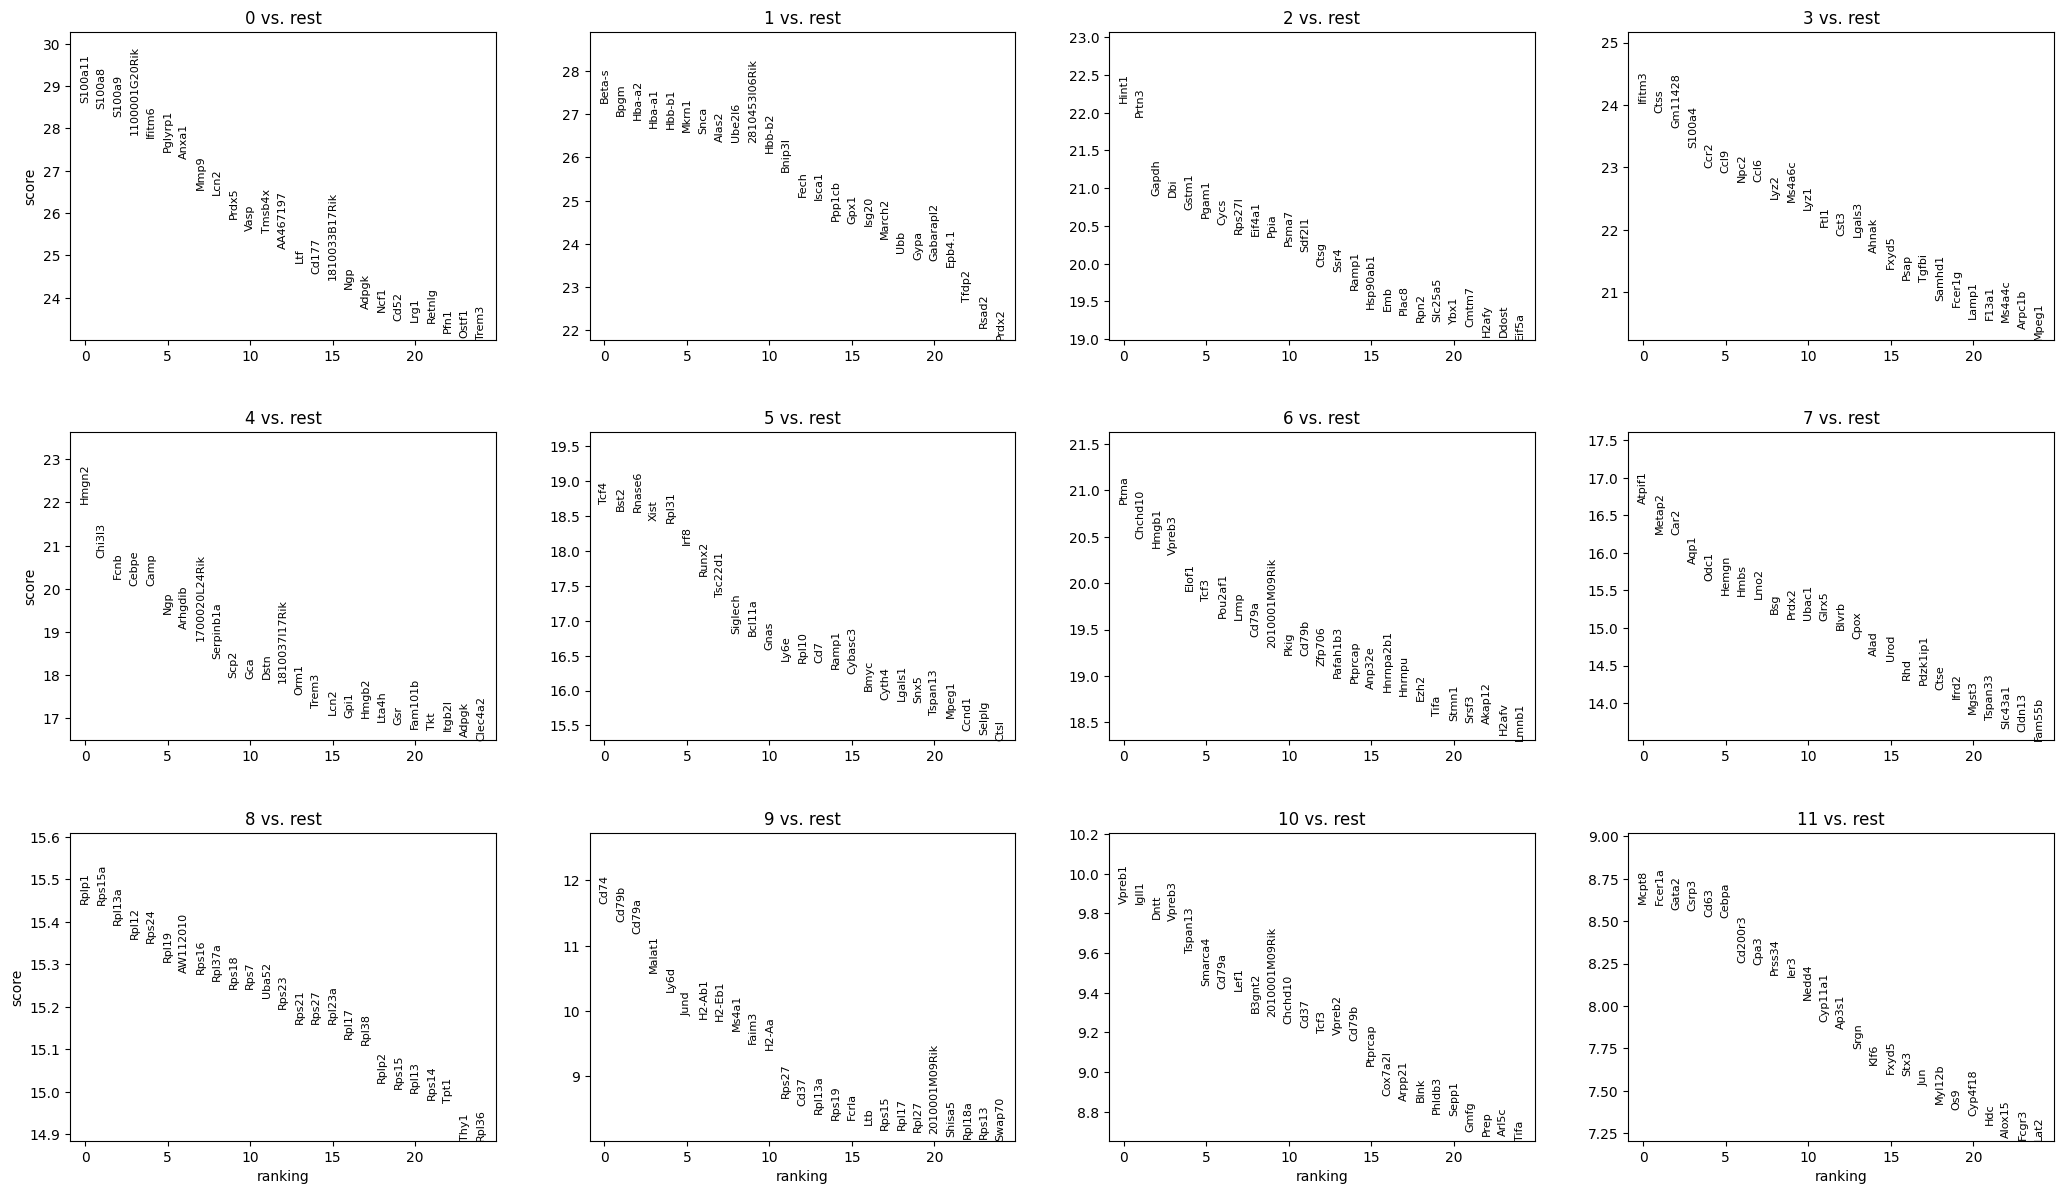

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)